<a href="https://colab.research.google.com/github/akshitasingh0706/DriftDetection/blob/main/DDClass_IMDb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Connect to Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


# Load Relevant Packages and Files from the Drift Detection Folder

In [2]:
!pip install -r /content/gdrive/MyDrive/DFCI/TestingPackage/DriftDetection/requirements.txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.7 MB 33.9 MB/s 
     |████████████████████████████████| 246 kB 69.1 MB/s 
     |████████████████████████████████| 85 kB 6.3 MB/s 
     |████████████████████████████████| 212 kB 29.3 MB/s 
     |████████████████████████████████| 4.4 MB 58.3 MB/s 
     |████████████████████████████████| 4.8 MB 60.0 MB/s 
     |████████████████████████████████| 6.6 MB 54.5 MB/s 
     |████████████████████████████████| 596 kB 61.1 MB/s 
     |████████████████████████████████| 101 kB 14.6 MB/s 
     |████████████████████████████████| 1.2 MB 64.5 MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125938 sha256=b1267d9062e274ca7b0a9a8dbe1cbe0469e66e394f537e2aa33ded96c190b467
  Stored in directory: /root/.cache/pip/wheels/bf/06/fb/d59c1e5bd1dac7f6cf61ec0036cc3a10ab8fecaa6b2c3d3ee9
Successfully built sentence-transfo

In [3]:
# manually 
import sys

filepath = '/content/gdrive/My Drive/DFCI/TestingPackage/DriftDetection' # please change to your own
sys.path.insert(0, filepath) # very important

In [4]:
from fileImports import imports 
samplingData, baseModels, embedding, distributions, detectors, AlibiDetectors = imports.run()

# Load and Process Data
This section is very user dependent. Data should be processed in the way best deamed by the user. The below example is just one very straightforward example of IMBD reviews present in the nlp package in python.

In [5]:
import nlp
import numpy as np
def load_dataset(dataset: str, split: str = 'test'):
    data = nlp.load_dataset(dataset)
    X, y = [], []
    for x in data[split]:
        X.append(x['text'])
        y.append(x['label'])
    X = np.array(X)
    y = np.array(y)
    return X, y
X, y = load_dataset('imdb', split='train')
print(X.shape, y.shape)

Downloading:   0%|          | 0.00/4.56k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.07k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/84.1M [00:00<?, ?B/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

Dataset imdb downloaded and prepared to /root/.cache/huggingface/datasets/imdb/plain_text/1.0.0/76cdbd7249ea3548c928bbf304258dab44d09cd3638d9da8d42480d1d1be3743. Subsequent calls will reuse this data.
(25000,) (25000,)


## Split data in pieces that we use for a) reference and b) possible drift

In [6]:
X1 = X[:round(X.shape[0]*.4)] # data_ref, data_h0
X2 = X[round(X.shape[0]*.4):] # data_h1

# Function parameters

## A note on selecting data for analyses
To detect drifts, we need to look into the "reference data" as well as the comparison data. A convenient (but not the only) way to divide our data for our analyses is as follows:
#### data_ref
(type: np.ndarray, list)
- This is the dataset on which is used as the reference/baseline when detecting drifts. For instance, if our test of choice is KL Divergence, then we will declare a possible drift based on whether any other data is close in distribution to data_ref. 
- Generally, the goal is to have all future datasets be as close (in embeddings, distributions)
to data_ref, which is how we conclude that there is no drift in the dataset.  
- data_ref is typically sampled from the "training data". During real world application, 
this is the data on which the test will be modeled on because this would generally be 
the only data the user would have access to at that point of time. 

#### data_h0
(type: np.ndarray, list (optional))
- This is generally the same dataset as data_ref (or a stream that comes soon after). We use the lack of drift in data_h0 (with data_ref as our reference) as the necessary condition to decide the robustness of the drift detection method.
- If the method ends up detecting a drift in data_h0 itself, we know it is most likely not doing a good job. This is because both data_ref and data_h0 are expected to be coming from the same source and hence should result in similar embeddings and distributions. If the user is confident in the efficacy of their drift detection method, then it would be worthwhile to consider change the size of data_ref and data_h0 and then re-evaluate detector performance, before proceeding to data_h1. 

#### data_h1
(type: np.ndarray, list)
- This is the primary dataset on which we can expect to possibly detect a drift. In the real world, this would usually be the dataset we get post model deployment. To test detectors, a convenient (but not necessarily the best) practice is to take the test data and use that as our proxy for the deployed dataset. 
- Multiple research papers and libraries tend to also use "perturbed" data for their choice of data_h1. Perturbations can include corruptions in images (vision data) or introduction of unneccessary words and phrases (text data). This is generally the first step in testing the efficacy of a drift detection method. Once again, if the detectors fails to detect a drift on manually perturbed data, then its quite likely it will not be able to detect drifts in the real, deployed data as well. 
- Therefore, for our purposes, we have tried to minimize the use of artifically perturbed data
and instead rely on test data/data from far away time periods as our data_h1 source. 

<a name="other-func-params"/>

## Note: Decription of other relevant parameters
#### test: str
Specify the kind of drift detection test we want: "KS", "KL", "JS", "MMD", "LSDD" (discussed below).

#### sample_size: int
Decides the number of samples from each of the above 3 datasets that we would like to work with. For instance, if the entire training data is 100K sentences, we can use a sample_size = 500 to randomly sample 500 of those sentences. 

#### drift_type: str
Specify the drift type we are looking for, based on the time/frquency: "Sudden", "Gradual" (discussed below). 

#### windows: int (optional)
This parameter is only required for gradual/incremental drift detection. This decided the number of segments we would like to break the data into. 
For instance, if data_h1 has 100K data points, and if we wish to detect drifts gradually over time, a proxy approach would be to break the data in sets of 5K points and then randomly sample from each set separately. 

#### embedding_model: str
This parameter decides the kind of embedding the text goes through. The embeddings we consider thus far are: \\
a) SBERT: A Python framework for state-of-the-art sentence, text and image embeddings. \\ 
b) Universal Sentence Encoders: USE encodes text into high dimensional vectors that can be used for text classification, semantic similarity, clustering, and other natural language tasks \\
c) Doc2Vec: a generalization of Word2Vec, which in turn is an algorithm that uses a 
neural network model to learn word associations from a large corpus of text

#### SBERT_model: str
This parameter is specific to the SBERT embedding models. If we choose to work with SBERT, we can specify the type of SBERT embedding out here. Ex. 'bert-base-uncased'

#### transformation:
Embeddings render multiple multi-dimensional vector spaces. For instance, USE results in 512 dimensions, and 'bert-base-uncased' results in 768 dimensions. For feature levels tests such  as KLD or JSD, such a large dimension might not be feasible to analyse, and thus we can reduce the dimensionality by selecting the most important components using methods such as PCA and SVD. 

#### iterations: int
We can run through multiple iterations of the embeddings to make our drift detection test more robust. For instance, if we only detect a drift on 1 out of 10 itertions, then we might be better off not flagging a drift at all.  


# Doc2Vec

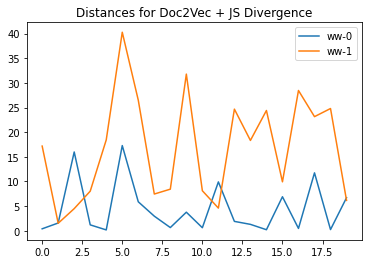

In [8]:
# define variables/parameters 
drift_type = "Sudden"
SBERT_model = None
embedding_model = "Doc2Vec" 
sample_size = 500
test = "JS"

# initialize the detector class with the above parameters
detect = detectors(data_ref = X1, data_h0 = X1, data_h1 = X2, test = test, drift_type = drift_type,
                sample_size = sample_size, embedding_model = embedding_model, SBERT_model = SBERT_model)
# run the code to get the detector results
result = detect.run() # change the term to "run" or "execute"

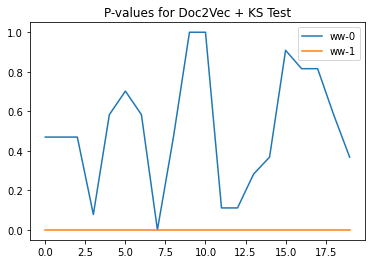

In [10]:
test = "KS"

detect = detectors(data_ref = X1, data_h0 = X1, data_h1 = X2, test = test, drift_type = drift_type,
                sample_size = sample_size, embedding_model = embedding_model, SBERT_model = SBERT_model)
result = detect.run()

# SBERT

Downloading:   0%|          | 0.00/437 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/11.4k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/9.01k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/440M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

No sentence-transformers model found with name /root/.cache/torch/sentence_transformers/bert-base-uncased. Creating a new one with MEAN pooling.
Some weights of the model checkpoint at /root/.cache/torch/sentence_transformers/bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertFor

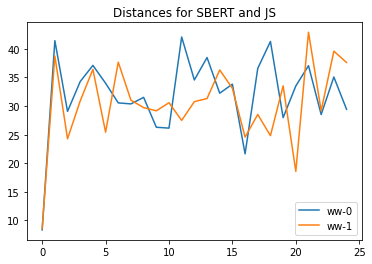

In [12]:
drift_type = "Sudden"
SBERT_model = 'bert-base-uncased'
embedding_model = "SBERT" 
sample_size = 150
test = "JS"
transformation = "PCA"
iterations = 1

detect = detectors(data_ref = X1, data_h0 = X1, data_h1 = X2, test = test, drift_type = drift_type,
                sample_size = sample_size, embedding_model = embedding_model, SBERT_model = SBERT_model,
                transformation = transformation, iterations = iterations)
result = detect.run()

In [13]:
test = "KS"

detect = detectors(data_ref = X1, data_h0 = X1, data_h1 = X2, test = test, drift_type = drift_type,
                sample_size = sample_size, embedding_model = embedding_model, SBERT_model = SBERT_model,
                transformation = transformation, iterations = iterations)
result = detect.run()

No sentence-transformers model found with name /root/.cache/torch/sentence_transformers/bert-base-uncased. Creating a new one with MEAN pooling.
Some weights of the model checkpoint at /root/.cache/torch/sentence_transformers/bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertFor

# AlibiDetectors

In [15]:
test = "MMDDrift"
sample_size = 200
windows = None
model_name = 'bert-base-uncased'


#alibi paramters
emb_type = 'hidden_state'
n_layers = 8
max_len = 100
enc_dim = 32 # for uae
tokenizer_size = 3
batch_size = 32

ab = AlibiDetectors(data_ref = X1, data_h0 = X2, data_h1 = X2,
                    test = test, sample_size = sample_size, windows = None,
                    drift_type = drift_type,  SBERT_model = SBERT_model,
                    
                    emb_type = emb_type, n_layers = n_layers, max_len = max_len,
                    enc_dim = enc_dim, tokenizer_size = tokenizer_size, batch_size = batch_size)

ab.predict()

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/511M [00:00<?, ?B/s]

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. 

Drift results for  X_h0 data using  MMDDrift test:
Drift? Yes!
p-value: 0.0
Drift results for  X_comp data using  MMDDrift test:
Drift? Yes!
p-value: 0.0


In [ ]:
test = "LSDDDrift"

ab = AlibiDetectors(data_ref = X1, data_h0 = X2, data_h1 = X2,
                    test = test, sample_size = sample_size, windows = None,
                    drift_type = drift_type,  model_name = model_name,
                    
                    emb_type = emb_type, n_layers = n_layers, max_len = max_len,
                    enc_dim = enc_dim, tokenizer_size = tokenizer_size, batch_size = batch_size)

ab.predict()

# Archive

In [ ]:
sampling = samplingData(data_ref = X1, data_h0 = X1, data_h1 = X2, 
                sample_size = 300, windows = None, drift_type = "Sudden")
sample_dict = sampling.samples()

In [ ]:
embs = embedding(data_ref = X1, data_h0 = X1, data_h1 = X2, test = "KL", 
                sample_size = 300, windows = None, drift_type = "Sudden", embedding_model = "Doc2Vec",
                model_name = model_name, transformation = None, emb_iters = 5)
final_dict = embs.final_embeddings()

In [ ]:
dis = distributions(data_ref = X1, data_h0 = X1, data_h1 = X2, transformation = None, windows = None, test = "KL",
                      drift_type = "Sudden", sample_size = 600, embedding_model = "Doc2Vec", iterations = 10)
final_dict = dis.final_distributions()